# Group 64: A Deep Look Into Mental Health Stigma in the Tech Workplace
<hr>

In [1]:
# Data wrangling and analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

# Data modeling
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Load the Data

In [2]:
mental14_df = pd.read_csv('data/mental_health_2014.csv')
mental16_df = pd.read_csv('data/mental_health_2016.csv')
mental16_meta_df = pd.read_json('data/mental_health_2016_meta_users.json')

## Describe the Data

### 2014/2015 Dataset Features
1. <b>date_submit</b>
2. <b>age</b>
3. <b>gender</b>
4. <b>country_live</b>
5. <b>state_live</b>: If you live in the United States, which state or territory do you live in?
6. <b>self_employed</b>: Are you self-employed?
7. <b>family_history</b>: Do you have a family history of mental illness?
8. <b>treatment</b>: Have you sought treatment for a mental health condition?
9. <b>work_interfere</b>: If you have a mental health condition, do you feel that it interferes with your work?
10. <b>num_employees</b>: How many employees does your company or organization have?
11. <b>remote</b>: Do you work remotely (outside of an office) at least 50% of the time?
12. <b>tech_company</b>: Is your employer primarily a tech company/organization?
13. <b>benefits</b>: Does your employer provide mental health benefits?
14. <b>care_options</b>: Do you know the options for mental health care your employer provides?
16. <b>wellness_program</b>: Has your employer ever discussed mental health as part of an employee wellness program?
16. <b>emp_help</b>: Does your employer provide resources to learn more about mental health issues and how to seek help?
17. <b>anon</b>: Is your anonymity protected if you choose to take advantage of mental health or substance abuse         treatment resources?
18. <b>med_leave</b>: How easy is it for you to take medical leave for a mental health condition?
19. <b>ment_conseq</b>: Do you think that discussing a mental health issue with your employer would have         negative consequences?
20. <b>phys_conseq</b>: Do you think that discussing a physical health issue with your employer would have         negative consequences?
21. <b>coworkers</b>: Would you be willing to discuss a mental health issue with your coworkers?
22. <b>supervisors</b>: Would you be willing to discuss a mental health issue with your direct supervisor(s)?
23. <b>ment_interv</b>: Would you bring up a mental health issue with a potential employer in an interview?
24. <b>phys_interv</b>: Would you bring up a physical health issue with a potential employer in an interview?
25. <b>ment_vs_phys</b>: Do you feel that your employer takes mental health as seriously as physical health?
26. <b>obs_conseq</b>: Have you heard of or observed negative consequences for coworkers with mental health               conditions in your workplace?
27. <b>comments</b>: Any additional notes or comments

### Try to Group the Features
##### About the person
datetime, country, state, age, gender, self_employed, no_employees, remote_work, tech_company, treatment
##### Workplace programs and benefits
benefits, care_options, wellness_program, seek_help, anonymity, leave
##### Stigma and comfort level
work_interfere, mental_health_consequence, phys_health_consequence, coworkers, supervisor, mental_health_interview, phys_health_interview, mental_vs_physical, obs_consequence, comments

### Observations
 - 2016 has more features than 2014
 - Empty values: state, self_employed, work_interfere, comments
 - Timestamp: 2014-08-27 to 2016-02-01
 - Age: 8 values that are impossible/highly unlikely
 - Gender: very messy with misspellings and nonstandard values
 - state: 4 rows where state given but country is not USA, 11 rows where country is USA but no state given
 - self_employed: 18 NaN values
 - work_interfere: 264 NaN values; people might've answered it based on 'treatment'
 - comments: 1095 NaN values
 - people picked "Don't know" a lot
 - many of the later questions are contingent upon earlier ones

### Actions
 - Timestamp: split into features "date" and "time"
 - Age: replace the 8 values with randomly generated values between mean +/- std
 - Gender: replace misspelled values with "m" and "f"; pool nonstandard values into "o" (other)
 - state: consider USA states on the level of countries? fill 11 USA unnamed states with median or mode
 - self_employed: drop all rows with Yes, assume NaN = No
 - work_interfere: fill NaN with 'Not Applicable' (based on the way it's phrased, people might've answered it based on the previous question (treatment); OR create own ordinal category; OR just drop it since 2016 phrases it differently
 - comment: drop column

In [3]:
mental14_df.shape

(1259, 27)

In [4]:
mental14_df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [5]:
mental14_relabels = [
    'date_submit', 'age', 'gender', 'country_live', 'state_live', 'self_employed', 'family_history', 'treatment',
    'work_interfere', 'num_employees', 'remote', 'tech_comp', 'benefits', 'care_options', 'wellness_program', 
    'emp_help', 'anon', 'med_leave', 'ment_conseq', 'phys_conseq', 'coworkers', 'supervisors', 'ment_interv',
    'phys_interv', 'ment_vs_phys', 'obs_conseq', 'comments' 
]

In [6]:
mental14_df.columns = mental14_relabels

In [7]:
mental14_df.head()

,date_submit,age,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [8]:
mental14_df.describe()

,age
count,1.259000e+03
mean,7.942815e+07
std,2.818299e+09
min,-1.726000e+03
25%,2.700000e+01
50%,3.100000e+01
75%,3.600000e+01
max,1.000000e+11


In [9]:
mental14_df.describe(include=['O'])

,date_submit,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,comments
count,1259,1259,1259,744,1241,1259,1259,995,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,164
unique,1246,49,48,45,2,2,2,4,6,2,2,3,3,3,3,3,5,3,3,3,3,3,3,3,2,160
top,2014-08-27 12:31:41,Male,United States,CA,No,No,Yes,Sometimes,6-25,No,Yes,Yes,No,No,No,Don't know,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,* Small family business - YMMV.
freq,2,615,751,138,1095,767,637,465,290,883,1031,477,501,842,646,819,563,490,925,774,516,1008,557,576,1075,5


In [10]:
mental14_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
date_submit         1259 non-null object
age                 1259 non-null int64
gender              1259 non-null object
country_live        1259 non-null object
state_live          744 non-null object
self_employed       1241 non-null object
family_history      1259 non-null object
treatment           1259 non-null object
work_interfere      995 non-null object
num_employees       1259 non-null object
remote              1259 non-null object
tech_comp           1259 non-null object
benefits            1259 non-null object
care_options        1259 non-null object
wellness_program    1259 non-null object
emp_help            1259 non-null object
anon                1259 non-null object
med_leave           1259 non-null object
ment_conseq         1259 non-null object
phys_conseq         1259 non-null object
coworkers           1259 non-null object
supervisors         1259 non-null o

In [11]:
mental14_df[mental14_df.duplicated("date_submit")]

,date_submit,age,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,comments
117,2014-08-27 12:31:41,27,Male,Canada,NaN,No,No,No,Rarely,6-25,No,No,Yes,Yes,Yes,Yes,Yes,Very easy,Maybe,No,Some of them,Yes,No,No,Don't know,No,NaN
139,2014-08-27 12:37:50,22,m,Austria,NaN,No,No,No,NaN,6-25,Yes,Yes,Don't know,No,Don't know,No,Don't know,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
158,2014-08-27 12:43:28,27,male,United States,UT,No,No,Yes,Rarely,26-100,Yes,Yes,No,Yes,No,No,Don't know,Somewhat difficult,Maybe,No,Some of them,Yes,No,No,Don't know,Yes,Had a co-worker disappear from work for a few ...
162,2014-08-27 12:44:51,31,M,United States,CA,No,No,No,Never,More than 1000,No,Yes,Yes,No,No,Yes,Don't know,Don't know,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
193,2014-08-27 12:54:11,35,Male,United States,CA,No,No,Yes,Rarely,6-25,No,Yes,No,No,No,No,Yes,Don't know,No,No,Some of them,Yes,No,No,Don't know,No,NaN
308,2014-08-27 14:22:43,25,Male,United States,OR,No,No,No,NaN,26-100,Yes,Yes,Don't know,Not sure,No,Don't know,Don't know,Don't know,No,No,Some of them,Yes,No,No,Don't know,No,NaN
385,2014-08-27 15:23:51,27,female,United States,CO,No,Yes,Yes,Rarely,More than 1000,Yes,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Maybe,Maybe,No,Yes,No,No,Don't know,No,NaN
391,2014-08-27 15:24:47,40,female,United States,PA,No,Yes,Yes,Rarely,More than 1000,No,No,Yes,No,Don't know,Don't know,Don't know,Somewhat easy,Maybe,Maybe,No,No,No,No,Don't know,No,NaN
454,2014-08-27 15:55:07,27,Male,United States,OR,No,Yes,Yes,Sometimes,100-500,No,Yes,Don't know,Not sure,No,Don't know,Don't know,Don't know,Yes,No,No,No,No,Yes,Don't know,No,NaN
528,2014-08-27 17:33:52,29,M,United States,NC,No,No,Yes,Sometimes,6-25,No,Yes,Yes,Yes,No,Yes,Yes,Very easy,No,No,No,Some of them,No,No,Yes,No,NaN


In [12]:
mental14_df.date_submit.min()

'2014-08-27 11:29:31'

In [13]:
mental14_df.date_submit.max()

'2016-02-01 23:04:31'

In [14]:
mental14_df.loc[(mental14_df.age > 80) | (mental14_df.age < 18)]

,date_submit,age,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,comments
143,2014-08-27 12:39:14,-29,Male,United States,MN,No,No,No,NaN,More than 1000,Yes,No,Yes,No,Don't know,Yes,Don't know,Don't know,No,No,Some of them,Yes,No,No,Don't know,No,NaN
364,2014-08-27 15:05:21,329,Male,United States,OH,No,No,Yes,Often,6-25,Yes,Yes,Yes,Yes,No,No,Don't know,Don't know,Maybe,No,Some of them,No,No,No,No,No,NaN
390,2014-08-27 15:24:47,99999999999,All,Zimbabwe,NaN,Yes,Yes,Yes,Often,1-5,No,Yes,No,Yes,No,No,No,Very difficult,Yes,Yes,No,No,Yes,No,No,Yes,NaN
715,2014-08-28 10:07:53,-1726,male,United Kingdom,NaN,No,No,Yes,Sometimes,26-100,No,No,No,No,No,No,Don't know,Somewhat difficult,Yes,No,No,No,No,Maybe,Don't know,No,NaN
734,2014-08-28 10:35:55,5,Male,United States,OH,No,No,No,NaN,100-500,No,Yes,Don't know,Not sure,No,No,Don't know,Somewhat easy,No,No,Yes,Yes,No,No,Yes,No,We had a developer suffer from depression and ...
989,2014-08-29 09:10:58,8,A little about you,"Bahamas, The",IL,Yes,Yes,Yes,Often,1-5,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Very easy,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,
1090,2014-08-29 17:26:15,11,male,United States,OH,Yes,No,No,Never,1-5,Yes,Yes,No,Yes,No,No,Yes,Very easy,No,No,Some of them,Some of them,No,Maybe,Yes,No,NaN
1127,2014-08-30 20:55:11,-1,p,United States,AL,Yes,Yes,Yes,Often,1-5,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Very easy,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,password: testered


In [15]:
mental14_df.gender.unique()

array(['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you',
       'Malr', 'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

In [16]:
mental14_df.country_live.value_counts(dropna=False)

United States             751
United Kingdom            185
Canada                     72
Germany                    45
Netherlands                27
Ireland                    27
Australia                  21
France                     13
India                      10
New Zealand                 8
Italy                       7
Switzerland                 7
Poland                      7
Sweden                      7
South Africa                6
Brazil                      6
Belgium                     6
Israel                      5
Bulgaria                    4
Singapore                   4
Austria                     3
Finland                     3
Mexico                      3
Russia                      3
Portugal                    2
Greece                      2
Colombia                    2
Croatia                     2
Denmark                     2
Bahamas, The                1
Slovenia                    1
Thailand                    1
Uruguay                     1
Hungary   

In [17]:
len(mental14_df.loc[(mental14_df.state_live.notnull()) & (mental14_df.country_live != 'United States')])

4

In [18]:
len(mental14_df.loc[(mental14_df.state_live.isnull()) & (mental14_df.country_live == 'United States')])

11

In [19]:
mental14_df.self_employed.value_counts(dropna=False)

No     1095
Yes     146
NaN      18
Name: self_employed, dtype: int64

In [20]:
mental14_df.work_interfere.value_counts(dropna=False)

Sometimes    465
NaN          264
Never        213
Rarely       173
Often        144
Name: work_interfere, dtype: int64

In [21]:
mental14_df.num_employees.value_counts(dropna=False)

6-25              290
26-100            289
More than 1000    282
100-500           176
1-5               162
500-1000           60
Name: num_employees, dtype: int64

In [22]:
mental14_df.benefits.value_counts(dropna=False)

Yes           477
Don't know    408
No            374
Name: benefits, dtype: int64

In [23]:
mental14_df.care_options.value_counts(dropna=False)

No          501
Yes         444
Not sure    314
Name: care_options, dtype: int64

In [24]:
mental14_df.wellness_program.value_counts(dropna=False)

No            842
Yes           229
Don't know    188
Name: wellness_program, dtype: int64

In [25]:
mental14_df.emp_help.value_counts(dropna=False)

No            646
Don't know    363
Yes           250
Name: emp_help, dtype: int64

In [26]:
mental14_df.anon.value_counts(dropna=False)

Don't know    819
Yes           375
No             65
Name: anon, dtype: int64

In [27]:
mental14_df.med_leave.value_counts(dropna=False)

Don't know            563
Somewhat easy         266
Very easy             206
Somewhat difficult    126
Very difficult         98
Name: med_leave, dtype: int64

In [28]:
mental14_df.ment_conseq.value_counts(dropna=False)

No       490
Maybe    477
Yes      292
Name: ment_conseq, dtype: int64

In [29]:
mental14_df.phys_conseq.value_counts(dropna=False)

No       925
Maybe    273
Yes       61
Name: phys_conseq, dtype: int64

In [30]:
mental14_df.coworkers.value_counts(dropna=False)

Some of them    774
No              260
Yes             225
Name: coworkers, dtype: int64

In [31]:
mental14_df.supervisors.value_counts(dropna=False)

Yes             516
No              393
Some of them    350
Name: supervisors, dtype: int64

In [32]:
mental14_df.ment_interv.value_counts(dropna=False)

No       1008
Maybe     207
Yes        44
Name: ment_interv, dtype: int64

In [33]:
mental14_df.phys_interv.value_counts(dropna=False)

Maybe    557
No       500
Yes      202
Name: phys_interv, dtype: int64

In [34]:
mental14_df.ment_vs_phys.value_counts(dropna=False)

Don't know    576
Yes           343
No            340
Name: ment_vs_phys, dtype: int64

In [35]:
len(mental14_df.comments.unique())

161

In [36]:
len(mental14_df.loc[mental14_df.comments.isnull()])

1095

In [37]:
mental14_df.loc[(mental14_df.self_employed == 'Yes') & (mental14_df.comments.notnull()), 'comments'].values

array([ "I'm not a permanent employee so do not get they benefits they get.My client is extremely supportive of permanent staff with mental health issues.",
       "Many of these questions become irrelevant once 'Yes' is selected for 'Are you self-employed'.  It would be preferable for there to be a 'Not Relevant' option on these.",
       "as a UK-based company we don't have any medical provisions as it's all provided on the National Health Service (for now!) However if we do need to take days off for any kind of health problems everyone is understanding :)",
       'Many of these questions were difficult to answer as a self-employed person; I did my best with the available options.',
       "I tried to answer as good as possible but I am CEO of a company so many questions don't fit very well.Also many of the questions are very US-centric in most systems healthcare is not your employers business.",
       "Some of these questions were difficult to answer as being self-employed they di

### Extract and Merge Timestamps Into 2016 DF

In [38]:
mental16_df.shape, mental16_meta_df.shape

((1433, 63), (1433, 5))

In [39]:
mental16_meta_df.head()

,answers,completed,hidden,metadata,token
0,"{'yesno_18065319': '0', 'list_18065482_choice'...",1,[],"{'browser': 'default', 'platform': 'other', 'd...",bbd31ae24e49278ea4f395cc2e4eb18b
1,"{'yesno_18065319': '0', 'list_18065482_choice'...",1,[],"{'browser': 'default', 'platform': 'other', 'd...",62ea0985724dbc093db89c4897bebf64
2,"{'yesno_18065319': '1', 'yesno_18065896': '1',...",1,[],"{'browser': 'default', 'platform': 'other', 'd...",759f9e4cf846da51a1bbe177edaf88a1
3,"{'yesno_18065319': '0', 'list_18065482_choice'...",1,[],"{'browser': 'default', 'platform': 'other', 'd...",67cd9bf06ae3b6b01b1e9d25026a833b
4,"{'yesno_18065319': '0', 'list_18065482_choice'...",1,[],"{'browser': 'touch', 'platform': 'mobile', 'da...",4259f743febf43743a05016834995e19


In [40]:
mental16_meta_df = pd.DataFrame.from_records(mental16_meta_df.metadata.values)

In [41]:
mental16_meta_df.head()

,browser,date_land,date_submit,network_id,platform,referer,user_agent
0,default,2016-03-14 13:54:17,2016-03-14 14:00:36,addd5ce59b,other,https://cojfunkatroncom.typeform.com/to/Ao6BTw,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...
1,default,2016-03-14 13:54:24,2016-03-14 14:03:32,c740939676,other,https://cojfunkatroncom.typeform.com/to/Ao6BTw,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...
2,default,2016-03-14 13:56:12,2016-03-14 14:16:30,4d75cc95d8,other,https://cojfunkatroncom.typeform.com/to/Ao6BTw,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...
3,default,2016-03-14 13:57:18,2016-03-14 18:20:55,2ab7bc287a,other,https://cojfunkatroncom.typeform.com/to/Ao6BTw,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...
4,touch,2016-03-14 13:59:51,2016-03-14 14:07:16,be9b12fba8,mobile,https://cojfunkatroncom.typeform.com/to/Ao6BTw,Mozilla/5.0 (Linux; Android 5.1.1; D6503 Build...


In [42]:
mental16_meta_df.drop(['browser', 'network_id', 'platform', 'referer'], axis=1, inplace=True)

In [43]:
mental16_meta_df.head()

,date_land,date_submit,user_agent
0,2016-03-14 13:54:17,2016-03-14 14:00:36,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...
1,2016-03-14 13:54:24,2016-03-14 14:03:32,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...
2,2016-03-14 13:56:12,2016-03-14 14:16:30,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...
3,2016-03-14 13:57:18,2016-03-14 18:20:55,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...
4,2016-03-14 13:59:51,2016-03-14 14:07:16,Mozilla/5.0 (Linux; Android 5.1.1; D6503 Build...


In [44]:
mental16_df = pd.concat([mental16_meta_df, mental16_df], axis=1)

### 2016 Dataset Features
1. <b>date_land</b> : datetime of when survey is first opened
2. <b>date_submit</b> : datetime of when survey is submitted
3. <b>user_agent</b> : user's browser and computer
4. <b>self_employed</b> : Are you self-employed?
5. <b>num_employees</b> : How many employees does your company or organization have?
6. <b>tech_comp</b> : Is your employer primarily a tech company/organization?
7. <b>tech_role</b> : Is your primary role within your company related to tech/IT?
8. <b>benefits</b> : Does your employer provide mental health benefits as part of healthcare coverage?
9. <b>care_options</b> : Do you know the options for mental health care available under your employer-provided coverage?
10. <b>wellness_program</b> : Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
11. <b>emp_help</b> : Does your employer offer resources to learn more about mental health concerns and options for seeking help?
12. <b>anon</b> : Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
13. <b>med_leave</b> : If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
14. <b>ment_conseq</b> : Do you think that discussing a mental health disorder with your employer would have negative consequences?
15. <b>phys_conseq</b> : Do you think that discussing a physical health issue with your employer would have negative consequences?
16. <b>coworkers</b> : Would you feel comfortable discussing a mental health disorder with your coworkers?
17. <b>supervisors</b> : Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?
18. <b>ment_vs_phys</b> : Do you feel that your employer takes mental health as seriously as physical health?
19. <b>obs_conseq</b> : Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?
20. <b>ment_med_cov</b> : Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?
21. <b>online_help</b> : Do you know local or online resources to seek help for a mental health disorder?
22. <b>reveal_clients</b> : If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?
23. <b>reveal_clients_neg</b> : If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?
24. <b>reveal_workers</b> : If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?
25. <b>reveal_workers_neg</b> : If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?
26. <b>productivity</b> : Do you believe your productivity is ever affected by a mental health issue?
27. <b>productivity_perc</b> : If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?
28. <b>prev_emps</b> : Do you have previous employers?
29. <b>pe_benefits</b> : Have your previous employers provided mental health benefits?
30. <b>pe_care_options</b> : Were you aware of the options for mental health care provided by your previous employers?
31. <b>pe_wellness_program</b> : Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?
32. <b>pe_emp_help</b> : Did your previous employers provide resources to learn more about mental health issues and how to seek help?
33. <b>pe_anon</b> : Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?
34. <b>pe_ment_conseq</b> : Do you think that discussing a mental health disorder with previous employers would have negative consequences?
35. <b>pe_phys_conseq</b> : Do you think that discussing a physical health issue with previous employers would have negative consequences?
36. <b>pe_coworkers</b> : Would you have been willing to discuss a mental health issue with your previous co-workers?
37. <b>pe_supervisors</b> : Would you feel comfortable discussing a mental health disorder with your previous direct supervisor(s)?
38. <b>pe_ment_vs_phys</b> : Did you feel that your previous employers took mental health as seriously as physical health?
39. <b>pe_obs_conseq</b> : Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?
40. <b>phys_interv</b> : Would you be willing to bring up a physical health issue with a potential employer in an interview?
41. <b>phys_interv_why</b> : Reason for choosing the above
42. <b>ment_interv</b> : Would you bring up a mental health issue with a potential employer in an interview?
43. <b>ment_interv_why</b> : Reason for choosing the above
44. <b>ment_hurt_career</b> : Do you feel that being identified as a person with a mental health issue would hurt your career?
45. <b>coworkers_neg</b> : Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?
46. <b>share_fam</b> : How willing would you be to share with friends and family that you have a mental illness?
47. <b>bad_event</b> : Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
48. <b>less_another</b> : Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?
49. <b>family_history</b> : Do you have a family history of mental illness?
50. <b>past_disorder</b> : Have you had a mental health disorder in the past?
51. <b>current_disorder</b> : Do you currently have a mental health disorder?
52. <b>yes_condition</b> : If yes, what condition(s) have you been diagnosed with?
53. <b>maybe_condition</b> : If maybe, what condition(s) do you believe you have?
54. <b>diagnosis</b> : Have you been diagnosed with a mental health condition by a medical professional?
55. <b>diag_condition</b> : If so, what condition(s) were you diagnosed with?
56. <b>treatment</b> : Have you ever sought treatment for a mental health issue from a mental health professional?
57. <b>interfere_treated</b> : If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?
58. <b>interfere_untreated</b> : If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
59. <b>age</b> : What is your age?
60. <b>gender</b> : What is your gender?
61. <b>country_live</b> : What country do you live in?
62. <b>state_live</b> : What US state or territory do you live in?
63. <b>country_work</b> : What country do you work in?
64. <b>state_work</b> : What US state or territory do you work in?
65. <b>job_position</b> : Which of the following best describes your work position?
66. <b>remote</b> : Do you work remotely?

### Extra Features Not in 2014 Dataset
1. tech_role
2. ment_med_cov
3. online_help
4. reveal_clients
5. reveal_clients_neg
6. reveal_workers
7. reveal_workers_neg
8. productivity
9. productivity_perc
10. prev_emps
11. pe_benefits
12. pe_care_options
13. pe_wellness_program
14. pe_emp_help
15. pe_anon
16. pe_ment_conseq
17. pe_phys_conseq
18. pe_coworkers
19. pe_supervisors
20. pe_ment_vs_phys
21. pe_obs_conseq
22. phys_interv_why
23. ment_interv_why
24. ment_hurt_career
25. coworkers_neg
26. share_fam
27. bad_event
28. less_another
29. past_disorder
30. current_disorder
31. yes_condition
32. maybe_condition
33. diagnosis
34. diag_condition
35. interfere_treated
36. interfere_untreated
37. country_work
38. state_work
39. job_position
40. date_land
41. user_agent
42. comments

### Observations
 - 2014 and 2016 has 25 features in common; 42 not in common
 - work_interfere is split into 2 questions in the 2016 dataset for untreated vs treated
 - 2016-03-14 to 2016-11-12
 - 1433 observations even though shorter timespan than the 2014 survey
 - age: same deal as 2014
 - gender: same deal as 2014
 - country and states looks to be clean
 - num_employees: 287 NaN values
 - benefits: 287 NaN values
 - care_options: 420 NaN
 - wellness_program: 287 NaN
 - emp_help: 287 NaN
 - anon: 287 NaN
 - med_leave: 287 NaN
 - ment_conseq: 287 NaN
 - phys_conseq: 287 NaN
 - coworkers: 287 NaN
 - supervisors: 287 NaN
 - ment_vs_phys: 287 NaN
 - Who are the 287 NaN people?
   - These are actually the self_employed people: most actually have the past_employer section filled out

### Actions
 - relabel 2016 to match 2014 for columns in common (DONE)
 - EITHER drop work_interfere from combined_df altogether; OR take the average of treated & untreated for each row (DONE)
 - Figure out what's the deal with the 287 NaN before combining
 - Timestamp: split into features "date" and "time"
 - Age: replace the outlier values with randomly generated values between mean +/- std
 - Gender: replace misspelled values with "m" and "f"; pool nonstandard values into "o" (other)
 - state: consider USA states on the level of countries since heavily skewed USA?
 - self_employed: fill NaN according to overall proportion of Yes:No
     - Lets drop it. Most of the questions wouldn't be very relevant for those people

In [45]:
mental16_relabels = [
    'date_land', 'date_submit', 'user_agent', 'self_employed', 'num_employees', 'tech_comp', 'tech_role',
    'benefits', 'care_options', 'wellness_program', 'emp_help', 'anon', 'med_leave', 'ment_conseq',
    'phys_conseq', 'coworkers', 'supervisors', 'ment_vs_phys', 'obs_conseq', 'ment_med_cov', 'online_help',
    'reveal_clients', 'reveal_clients_neg', 'reveal_workers', 'reveal_workers_neg', 'productivity',
    'productivity_perc', 'prev_emps', 'pe_benefits', 'pe_care_options', 'pe_wellness_program', 'pe_emp_help',
    'pe_anon', 'pe_ment_conseq', 'pe_phys_conseq', 'pe_coworkers', 'pe_supervisors', 'pe_ment_vs_phys',
    'pe_obs_conseq', 'phys_interv', 'phys_interv_why', 'ment_interv', 'ment_interv_why', 'ment_hurt_career',
    'coworkers_neg', 'share_fam', 'bad_event', 'less_another', 'family_history', 'past_disorder',
    'current_disorder', 'yes_condition', 'maybe_condition', 'diagnosis', 'diag_condition', 'treatment',
    'interfere_treated', 'interfere_untreated', 'age', 'gender', 'country_live', 'state_live', 'country_work',
    'state_work', 'job_position', 'remote'
]

In [46]:
mental16_df.columns = mental16_relabels

In [47]:
mental16_df.head()

,date_land,date_submit,user_agent,self_employed,num_employees,tech_comp,tech_role,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,ment_med_cov,online_help,reveal_clients,reveal_clients_neg,reveal_workers,reveal_workers_neg,productivity,productivity_perc,prev_emps,pe_benefits,pe_care_options,pe_wellness_program,pe_emp_help,pe_anon,pe_ment_conseq,pe_phys_conseq,pe_coworkers,pe_supervisors,pe_ment_vs_phys,pe_obs_conseq,phys_interv,phys_interv_why,ment_interv,ment_interv_why,ment_hurt_career,coworkers_neg,share_fam,bad_event,less_another,family_history,past_disorder,current_disorder,yes_condition,maybe_condition,diagnosis,diag_condition,treatment,interfere_treated,interfere_untreated,age,gender,country_live,state_live,country_work,state_work,job_position,remote
0,2016-03-14 13:54:17,2016-03-14 14:00:36,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,No,No,Maybe,Yes,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),I don't know,None did,I don't know,Some of them,None of them,Some of my previous employers,Some of my previous employers,I don't know,None of them,Maybe,NaN,Maybe,NaN,Maybe,"No, I don't think they would",Somewhat open,No,NaN,No,Yes,No,NaN,NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",0,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,2016-03-14 13:54:24,2016-03-14 14:03:32,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,No,No,Maybe,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"Yes, they all did",I was aware of some,None did,Some did,"Yes, always",None of them,None of them,"No, at none of my previous employers",Some of my previous employers,Some did,None of them,Maybe,It would depend on the health issue. If there ...,No,While mental health has become a more prominen...,"No, I don't think it would","No, I don't think they would",Somewhat open,No,NaN,Yes,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,2016-03-14 13:56:12,2016-03-14 14:16:30,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,Maybe,No,Maybe,Maybe,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),None did,Some did,I don't know,I don't know,Some of them,Some of my previous employers,I don't know,I don't know,Some of them,Yes,"They would provable need to know, to Judge if ...",Yes,"Stigma, mainly.",Maybe,Maybe,Somewhat open,Maybe/Not sure,Yes,No,Maybe,No,NaN,NaN,No,NaN,1,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always
3,2016-03-14 13:57:18,2016-03-14 18:20:55,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"Yes, I know several","Sometimes, if it comes up",I'm not sure,"Sometimes, if it comes up",I'm not sure,Yes,1-25%,1,Some did,N/A (not currently aware),None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,I don't know,Some of them,Yes,"old back injury, doesn't cause me many issues ...",Maybe,would not if I was not 100% sure that the disc...,"Yes, I think it would",Maybe,Neutral,No,NaN,No,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes
4,2016-03-14 13:59:51,2016-03-14 14:07:16,Mozilla/5.0 (Linux; Android 5.1.1; D6503 Build...,0,6-25,0.0,1.0,Yes,Ye

### Create work_interfere Feature

In [48]:
work_interfere_to_num = {'Not applicable to me': 0, 'Never': 1, 'Rarely': 2, 'Sometimes': 3, 'Often': 4}
num_to_work_interfere = {0: 'Not applicable to me', 1: 'Never', 2: 'Rarely', 3: 'Sometimes', 4: 'Often'}
work_interfere = []

for ind, row in mental16_df[['interfere_untreated', 'interfere_treated']].iterrows():
    # if 'Not applicable' for either column then add the other one that has a value
    row_mapped = row.map(work_interfere_to_num)
    if row_mapped[0] == 0 or row_mapped[1] == 0:
        work_interfere.append(row_mapped.max())
    # else take the average between both columns and randomly round up or down
    else:
        temp_val = row_mapped.mean()
        round_up_down = np.random.randint(0, 2)
        if not temp_val.is_integer():
            if round_up_down == 0:
                temp_val = np.floor(temp_val)
            if round_up_down == 1:
                temp_val = np.ceil(temp_val)
        work_interfere.append(int(temp_val))
work_interfere = pd.Series(work_interfere).map(num_to_work_interfere)

In [49]:
mental16_df['work_interfere'] = work_interfere

In [50]:
mental16_df.shape

(1433, 67)

In [51]:
mental16_df.head()

,date_land,date_submit,user_agent,self_employed,num_employees,tech_comp,tech_role,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,ment_med_cov,online_help,reveal_clients,reveal_clients_neg,reveal_workers,reveal_workers_neg,productivity,productivity_perc,prev_emps,pe_benefits,pe_care_options,pe_wellness_program,pe_emp_help,pe_anon,pe_ment_conseq,pe_phys_conseq,pe_coworkers,pe_supervisors,pe_ment_vs_phys,pe_obs_conseq,phys_interv,phys_interv_why,ment_interv,ment_interv_why,ment_hurt_career,coworkers_neg,share_fam,bad_event,less_another,family_history,past_disorder,current_disorder,yes_condition,maybe_condition,diagnosis,diag_condition,treatment,interfere_treated,interfere_untreated,age,gender,country_live,state_live,country_work,state_work,job_position,remote,work_interfere
0,2016-03-14 13:54:17,2016-03-14 14:00:36,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,No,No,Maybe,Yes,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),I don't know,None did,I don't know,Some of them,None of them,Some of my previous employers,Some of my previous employers,I don't know,None of them,Maybe,NaN,Maybe,NaN,Maybe,"No, I don't think they would",Somewhat open,No,NaN,No,Yes,No,NaN,NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",0,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes,Not applicable to me
1,2016-03-14 13:54:24,2016-03-14 14:03:32,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,No,No,Maybe,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"Yes, they all did",I was aware of some,None did,Some did,"Yes, always",None of them,None of them,"No, at none of my previous employers",Some of my previous employers,Some did,None of them,Maybe,It would depend on the health issue. If there ...,No,While mental health has become a more prominen...,"No, I don't think it would","No, I don't think they would",Somewhat open,No,NaN,Yes,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never,Rarely
2,2016-03-14 13:56:12,2016-03-14 14:16:30,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,Maybe,No,Maybe,Maybe,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),None did,Some did,I don't know,I don't know,Some of them,Some of my previous employers,I don't know,I don't know,Some of them,Yes,"They would provable need to know, to Judge if ...",Yes,"Stigma, mainly.",Maybe,Maybe,Somewhat open,Maybe/Not sure,Yes,No,Maybe,No,NaN,NaN,No,NaN,1,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always,Not applicable to me
3,2016-03-14 13:57:18,2016-03-14 18:20:55,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"Yes, I know several","Sometimes, if it comes up",I'm not sure,"Sometimes, if it comes up",I'm not sure,Yes,1-25%,1,Some did,N/A (not currently aware),None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,I don't know,Some of them,Yes,"old back injury, doesn't cause me many issues ...",Maybe,would not if I was not 100% sure that the disc...,"Yes, I think it would",Maybe,Neutral,No,NaN,No,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes,Sometimes
4,2016-03-14 13:59:51,2016-03-14 14:07:

In [52]:
mental16_df.describe()

,self_employed,tech_comp,tech_role,ment_med_cov,prev_emps,treatment,age
count,1433.000000,1146.000000,263.000000,287.000000,1433.000000,1433.000000,1433.000000
mean,0.200279,0.770506,0.942966,0.644599,0.882066,0.585485,34.286113
std,0.400349,0.420691,0.232350,0.479471,0.322643,0.492810,11.290931
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,28.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,39.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,323.000000


In [53]:
mental16_df.describe(include=['O'])

,date_land,date_submit,user_agent,num_employees,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,online_help,reveal_clients,reveal_clients_neg,reveal_workers,reveal_workers_neg,productivity,productivity_perc,pe_benefits,pe_care_options,pe_wellness_program,pe_emp_help,pe_anon,pe_ment_conseq,pe_phys_conseq,pe_coworkers,pe_supervisors,pe_ment_vs_phys,pe_obs_conseq,phys_interv,phys_interv_why,ment_interv,ment_interv_why,ment_hurt_career,coworkers_neg,share_fam,bad_event,less_another,family_history,past_disorder,current_disorder,yes_condition,maybe_condition,diagnosis,diag_condition,interfere_treated,interfere_untreated,gender,country_live,state_live,country_work,state_work,job_position,remote,work_interfere
count,1433,1433,1433,1146,1146,1013,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,287,287,144,287,287,287,204,1264,1264,1264,1264,1264,1264,1264,1264,1264,1264,1264,1433,1096,1433,1127,1433,1433,1433,1344,657,1433,1433,1433,568,322,1433,711,1433,1433,1430,1433,840,1433,851,1433,1433,1433
unique,1433,1430,504,6,4,3,3,3,3,6,3,3,3,3,3,2,3,5,3,5,4,4,4,4,4,4,3,4,4,3,3,4,4,3,3,1086,3,1081,5,5,6,4,3,3,3,3,128,99,2,116,5,5,70,53,47,53,48,264,3,5
top,2016-03-16 14:34:36,2016-03-28 15:23:16,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...,26-100,Yes,No,No,No,I don't know,Somewhat easy,Maybe,No,Maybe,Yes,I don't know,No,I know some,Not applicable to me,I'm not sure,Not applicable to me,Not applicable to me,Yes,1-25%,Some did,N/A (not currently aware),None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,None did,None of them,Maybe,Fear of discrimination,No,Stigma,Maybe,Maybe,Somewhat open,No,Yes,Yes,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...","Mood Disorder (Depression, Bipolar Disorder, etc)",No,"Mood Disorder (Depression, Bipolar Disorder, etc)",Not applicable to me,Often,Male,United States of America,California,United States of America,California,Back-end Developer,Sometimes,Sometimes
freq,1,2,82,292,531,354,813,531,742,281,487,837,479,428,493,1048,141,101,66,111,133,204,92,391,582,890,842,860,615,631,740,654,463,758,633,3,883,14,588,591,640,567,246,670,736,575,117,55,717,187,557,538,610,840,130,851,141,263,757,561


In [54]:
mental16_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 67 columns):
date_land              1433 non-null object
date_submit            1433 non-null object
user_agent             1433 non-null object
self_employed          1433 non-null int64
num_employees          1146 non-null object
tech_comp              1146 non-null float64
tech_role              263 non-null float64
benefits               1146 non-null object
care_options           1013 non-null object
wellness_program       1146 non-null object
emp_help               1146 non-null object
anon                   1146 non-null object
med_leave              1146 non-null object
ment_conseq            1146 non-null object
phys_conseq            1146 non-null object
coworkers              1146 non-null object
supervisors            1146 non-null object
ment_vs_phys           1146 non-null object
obs_conseq             1146 non-null object
ment_med_cov           287 non-null float64
online_help  

In [55]:
mental16_df[mental16_df.duplicated('date_submit')]

,date_land,date_submit,user_agent,self_employed,num_employees,tech_comp,tech_role,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,ment_med_cov,online_help,reveal_clients,reveal_clients_neg,reveal_workers,reveal_workers_neg,productivity,productivity_perc,prev_emps,pe_benefits,pe_care_options,pe_wellness_program,pe_emp_help,pe_anon,pe_ment_conseq,pe_phys_conseq,pe_coworkers,pe_supervisors,pe_ment_vs_phys,pe_obs_conseq,phys_interv,phys_interv_why,ment_interv,ment_interv_why,ment_hurt_career,coworkers_neg,share_fam,bad_event,less_another,family_history,past_disorder,current_disorder,yes_condition,maybe_condition,diagnosis,diag_condition,treatment,interfere_treated,interfere_untreated,age,gender,country_live,state_live,country_work,state_work,job_position,remote,work_interfere
563,2016-03-24 15:35:35,2016-03-24 15:41:08,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"No, I don't know any",Not applicable to me,NaN,Not applicable to me,Not applicable to me,Yes,1-25%,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,not his concern,No,if he does his work correctly why should i,"No, I don't think it would","No, they do not",Somewhat open,NaN,NaN,Yes,No,No,NaN,NaN,No,NaN,0,Not applicable to me,Not applicable to me,30,male,Poland,NaN,Poland,NaN,Supervisor/Team Lead|DevOps/SysAdmin|Back-end ...,Always,Not applicable to me
628,2016-03-28 14:54:45,2016-03-28 14:59:38,Mozilla/5.0 (iPad; CPU OS 8_2 like Mac OS X) A...,0,More than 1000,1.0,NaN,Yes,I am not sure,No,Yes,I don't know,Somewhat difficult,Maybe,No,Maybe,Maybe,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,I don't know,N/A (not currently aware),None did,None did,I don't know,I don't know,None of them,Some of my previous employers,Some of my previous employers,Some did,None of them,No,if it did not affect my job performance i woul...,No,i would be afraid of bias in their decision ma...,Maybe,Maybe,Somewhat not open,Maybe/Not sure,Yes,I don't know,Maybe,Yes,"Mood Disorder (Depression, Bipolar Disorder, etc)",NaN,Yes,"Mood Disorder (Depression, Bipolar Disorder, etc)",0,Not applicable to me,Rarely,42,Male,United States of America,New Hampshire,United States of America,Massachusetts,Supervisor/Team Lead,Sometimes,Rarely
650,2016-03-28 15:18:24,2016-03-28 15:23:16,Mozilla/5.0 (Linux; Android 5.1; XT1032 Build/...,0,6-25,1.0,NaN,No,No,No,No,Yes,Very difficult,Yes,Yes,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did","No, I only became aware later",I don't know,None did,"Yes, always","Yes, all of them","Yes, all of them","No, at none of my previous employers","No, at none of my previous employers",None did,"Yes, all of them",No,because it would kill my job chances,No,because it would kill my chances at the job,"Yes, I think it would","Yes, I think they would",Somewhat open,Maybe/Not sure,Yes,No,No,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Often,30,male,Canada,NaN,Canada,NaN,Front-end Developer|Designer,Never,Sometimes


In [56]:
mental16_df.date_submit.min()

'2016-03-14 14:00:36'

In [57]:
mental16_df.date_submit.max()

'2016-11-12 06:05:16'

In [58]:
mental16_df.loc[(mental16_df.age > 80) | (mental16_df.age < 18)]

,date_land,date_submit,user_agent,self_employed,num_employees,tech_comp,tech_role,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,ment_med_cov,online_help,reveal_clients,reveal_clients_neg,reveal_workers,reveal_workers_neg,productivity,productivity_perc,prev_emps,pe_benefits,pe_care_options,pe_wellness_program,pe_emp_help,pe_anon,pe_ment_conseq,pe_phys_conseq,pe_coworkers,pe_supervisors,pe_ment_vs_phys,pe_obs_conseq,phys_interv,phys_interv_why,ment_interv,ment_interv_why,ment_hurt_career,coworkers_neg,share_fam,bad_event,less_another,family_history,past_disorder,current_disorder,yes_condition,maybe_condition,diagnosis,diag_condition,treatment,interfere_treated,interfere_untreated,age,gender,country_live,state_live,country_work,state_work,job_position,remote,work_interfere
93,2016-03-14 16:16:16,2016-03-14 16:27:41,Mozilla/5.0 (iPhone; CPU iPhone OS 9_2_1 like ...,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Somewhat difficult,Yes,No,No,Yes,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),None did,None did,I don't know,Some of them,None of them,"No, at none of my previous employers",I don't know,Some did,None of them,Yes,Starting a job hiding something like this can ...,Yes,Same response as the physical one.,Maybe,"Yes, I think they would",Not open at all,"Yes, I observed",Yes,No,No,No,NaN,NaN,No,NaN,0,Never,Sometimes,17,male,Brazil,NaN,Brazil,NaN,Front-end Developer,Always,Rarely
372,2016-03-16 19:37:09,2016-03-16 19:43:12,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...,0,6-25,1.0,NaN,Yes,No,No,I don't know,Yes,Somewhat easy,No,No,Yes,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Some did,N/A (not currently aware),None did,None did,No,"Yes, all of them","Yes, all of them",Some of my previous employers,Some of my previous employers,Some did,"Yes, all of them",Yes,"It would be something they would need to know,...",Maybe,"It depends on the employer. See, it's difficul...",Maybe,"No, I don't think they would",Somewhat open,"Yes, I experienced",Yes,Yes,Yes,Yes,Traumatic Brain Injury,NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Often,99,Other,United States of America,Michigan,United States of America,Michigan,Supervisor/Team Lead,Sometimes,Sometimes
564,2016-03-24 15:37:55,2016-03-24 15:42:56,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,100-500,1.0,NaN,Yes,No,I don't know,I don't know,I don't know,I don't know,No,No,Maybe,Maybe,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Some did,N/A (not currently aware),None did,None did,I don't know,I don't know,Some of them,Some of my previous employers,Some of my previous employers,None did,Some of them,Yes,It may affect time I need to take off or my ab...,Maybe,It hasn't come up for me.,Maybe,"No, I don't think they would",Neutral,Maybe/Not sure,NaN,Yes,No,No,NaN,NaN,No,NaN,0,Not applicable to me,Not applicable to me,323,Male,United States of America,Oregon,United States of America,Oregon,Back-end Developer,Sometimes,Not applicable to me
656,2016-03-28 15:28:47,2016-03-28 15:37:29,Mozilla/5.0 (iPhone; CPU iPhone OS 9_2_1 like ...,0,More than 1000,1.0,NaN,Yes,I am not sure,Yes,Yes,I don't know,Somewhat easy,Maybe,No,Maybe,Yes,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Some did,I was aware of some,None did,Some did,I don't know,Some of them,Some of them,"No, at none of my previous employers",Some of my previous employers,I don't know,None of them,Maybe,Legislation in my jurisdiction mandates certai...,No,"Despite the legal protections, mental health i...",Maybe,"No, I don't think they would",Somewhat open,Maybe/Not sure,Maybe,I don't know,Yes,Maybe,NaN,"Anxiety Disorder (Generalized, Social, Phobia,...",Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Sometimes,3,Male,Canada,NaN,Canada,NaN,Back-end Developer,Sometimes,Rarely
808,2016-03-29 03:47:52,2016-03-29 03:59:41,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1,NaN

In [59]:
mental16_df.gender.unique()

array(['Male', 'male', 'Male ', 'Female', 'M', 'female', 'm',
       'I identify as female.', 'female ', 'Bigender', 'non-binary',
       'Female assigned at birth ', 'F', 'Woman', 'man', 'fm', 'f',
       'Cis female ', 'Transitioned, M2F', 'Genderfluid (born female)',
       'Other/Transfeminine', 'Female or Multi-Gender Femme', 'Female ',
       'woman', 'female/woman', 'Cis male', 'Male.', 'Androgynous',
       'male 9:1 female, roughly', nan, 'Male (cis)', 'Other',
       'nb masculine', 'Cisgender Female', 'Man', 'Sex is male',
       'none of your business', 'genderqueer', 'cis male', 'Human',
       'Genderfluid', 'Enby', 'Malr', 'genderqueer woman', 'mtf', 'Queer',
       'Agender', 'Dude', 'Fluid',
       "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
       'mail', 'M|', 'Male/genderqueer', 'fem', 'Nonbinary', 'male ',
       'human', 'Female (props for making th

In [60]:
mental16_df.country_live.value_counts(dropna=False)

United States of America    840
United Kingdom              180
Canada                       78
Germany                      58
Netherlands                  48
Australia                    35
Sweden                       19
France                       16
Ireland                      15
Brazil                       10
Switzerland                  10
New Zealand                   9
Russia                        9
India                         9
Bulgaria                      7
Finland                       7
Denmark                       7
Belgium                       5
Italy                         5
Spain                         4
South Africa                  4
Poland                        4
Romania                       4
Austria                       4
Chile                         3
Norway                        3
Pakistan                      3
Czech Republic                3
Israel                        2
Lithuania                     2
Japan                         2
Colombia

In [61]:
len(mental16_df.loc[(mental16_df.state_live.notnull()) & (mental16_df.country_live != 'United States of America')])

0

In [62]:
len(mental16_df.loc[(mental16_df.state_live.isnull()) & (mental16_df.country_live == 'United States of America')])

0

In [63]:
mental16_df.self_employed.value_counts(dropna=False)

0    1146
1     287
Name: self_employed, dtype: int64

In [64]:
mental16_df.num_employees.value_counts(dropna=False)

26-100            292
NaN               287
More than 1000    256
100-500           248
6-25              210
500-1000           80
1-5                60
Name: num_employees, dtype: int64

In [65]:
mental16_df.work_interfere.value_counts(dropna=False)

Sometimes               561
Not applicable to me    452
Often                   205
Rarely                  194
Never                    21
Name: work_interfere, dtype: int64

In [66]:
mental16_df.benefits.value_counts(dropna=False)

Yes                                531
I don't know                       319
NaN                                287
No                                 213
Not eligible for coverage / N/A     83
Name: benefits, dtype: int64

In [67]:
mental16_df.care_options.value_counts(dropna=False)

NaN              420
No               354
I am not sure    352
Yes              307
Name: care_options, dtype: int64

In [68]:
mental16_df.wellness_program.value_counts(dropna=False)

No              813
NaN             287
Yes             230
I don't know    103
Name: wellness_program, dtype: int64

In [69]:
mental16_df.emp_help.value_counts(dropna=False)

No              531
I don't know    320
Yes             295
NaN             287
Name: emp_help, dtype: int64

In [70]:
mental16_df.anon.value_counts(dropna=False)

I don't know    742
Yes             320
NaN             287
No               84
Name: anon, dtype: int64

In [71]:
mental16_df.med_leave.value_counts(dropna=False)

NaN                           287
Somewhat easy                 281
Very easy                     220
Somewhat difficult            199
Neither easy nor difficult    178
I don't know                  150
Very difficult                118
Name: med_leave, dtype: int64

In [72]:
mental16_df.ment_conseq.value_counts(dropna=False)

Maybe    487
No       438
NaN      287
Yes      221
Name: ment_conseq, dtype: int64

In [73]:
mental16_df.phys_conseq.value_counts(dropna=False)

No       837
NaN      287
Maybe    268
Yes       41
Name: phys_conseq, dtype: int64

In [74]:
mental16_df.coworkers.value_counts(dropna=False)

Maybe    479
No       392
NaN      287
Yes      275
Name: coworkers, dtype: int64

In [75]:
mental16_df.supervisors.value_counts(dropna=False)

Yes      428
Maybe    382
No       336
NaN      287
Name: supervisors, dtype: int64

In [76]:
mental16_df.ment_interv.value_counts(dropna=False)

No       883
Maybe    438
Yes      112
Name: ment_interv, dtype: int64

In [77]:
mental16_df.phys_interv.value_counts(dropna=False)

Maybe    633
No       441
Yes      359
Name: phys_interv, dtype: int64

In [78]:
mental16_df.ment_vs_phys.value_counts(dropna=False)

I don't know    493
Yes             350
No              303
NaN             287
Name: ment_vs_phys, dtype: int64

In [79]:
mental16_df.loc[mental16_df.num_employees.isnull()]

,date_land,date_submit,user_agent,self_employed,num_employees,tech_comp,tech_role,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,ment_med_cov,online_help,reveal_clients,reveal_clients_neg,reveal_workers,reveal_workers_neg,productivity,productivity_perc,prev_emps,pe_benefits,pe_care_options,pe_wellness_program,pe_emp_help,pe_anon,pe_ment_conseq,pe_phys_conseq,pe_coworkers,pe_supervisors,pe_ment_vs_phys,pe_obs_conseq,phys_interv,phys_interv_why,ment_interv,ment_interv_why,ment_hurt_career,coworkers_neg,share_fam,bad_event,less_another,family_history,past_disorder,current_disorder,yes_condition,maybe_condition,diagnosis,diag_condition,treatment,interfere_treated,interfere_untreated,age,gender,country_live,state_live,country_work,state_work,job_position,remote,work_interfere
3,2016-03-14 13:57:18,2016-03-14 18:20:55,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"Yes, I know several","Sometimes, if it comes up",I'm not sure,"Sometimes, if it comes up",I'm not sure,Yes,1-25%,1,Some did,N/A (not currently aware),None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,I don't know,Some of them,Yes,"old back injury, doesn't cause me many issues ...",Maybe,would not if I was not 100% sure that the disc...,"Yes, I think it would",Maybe,Neutral,No,NaN,No,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes,Sometimes
9,2016-03-14 14:07:47,2016-03-14 14:28:47,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,I know some,"No, because it doesn't matter",NaN,"Sometimes, if it comes up",No,Yes,1-25%,1,Some did,I was aware of some,None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,I don't know,None of them,Yes,"Generally speaking, and this isn't always the ...",Maybe,"It really depends on the person, the employer,...",Maybe,"No, I don't think they would",Very open,No,NaN,Yes,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Often,30,Male,United States of America,Kentucky,United States of America,Kentucky,One-person shop|Front-end Developer|Back-end D...,Always,Sometimes
18,2016-03-14 14:25:21,2016-03-14 14:37:10,Mozilla/5.0 (iPhone; CPU iPhone OS 9_2_1 like ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,I know some,"No, because it would impact me negatively",Yes,"No, because it would impact me negatively",Yes,Yes,76-100%,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,No,bad idea,"Yes, it has","Yes, they do",Somewhat not open,"Yes, I observed",Yes,I don't know,Yes,Yes,"Personality Disorder (Borderline, Antisocial, ...",NaN,Yes,"Personality Disorder (Borderline, Antisocial, ...",1,Often,Often,25,female,United States of America,Washington,United States of America,Washington,One-person shop,Always,Often
24,2016-03-14 14:33:31,2016-03-14 14:37:00,Mozilla/5.0 (iPhone; CPU iPhone OS 9_2_1 like ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,I know some,Not applicable to me,NaN,Not applicable to me,Not applicable to me,Not applicable to me,NaN,1,I don't know,"No, I only became aware later",None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,I don't know,Some of them,Maybe,Only if it would impact my performance to the ...,Maybe,"Again, only if it could effect my job performance",Maybe,"No, I don't think they would",Not applicable to me (I do not have a mental i...,NaN,NaN,No,No,No,NaN,NaN,No,NaN,0,Not applicable to me,Not applicable to me,38,Male,United Stat

In [80]:
len(mental16_df.loc[mental16_df.self_employed == 1])

287

In [81]:
mental16_df.loc[mental16_df.self_employed == 1]

,date_land,date_submit,user_agent,self_employed,num_employees,tech_comp,tech_role,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,ment_med_cov,online_help,reveal_clients,reveal_clients_neg,reveal_workers,reveal_workers_neg,productivity,productivity_perc,prev_emps,pe_benefits,pe_care_options,pe_wellness_program,pe_emp_help,pe_anon,pe_ment_conseq,pe_phys_conseq,pe_coworkers,pe_supervisors,pe_ment_vs_phys,pe_obs_conseq,phys_interv,phys_interv_why,ment_interv,ment_interv_why,ment_hurt_career,coworkers_neg,share_fam,bad_event,less_another,family_history,past_disorder,current_disorder,yes_condition,maybe_condition,diagnosis,diag_condition,treatment,interfere_treated,interfere_untreated,age,gender,country_live,state_live,country_work,state_work,job_position,remote,work_interfere
3,2016-03-14 13:57:18,2016-03-14 18:20:55,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"Yes, I know several","Sometimes, if it comes up",I'm not sure,"Sometimes, if it comes up",I'm not sure,Yes,1-25%,1,Some did,N/A (not currently aware),None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,I don't know,Some of them,Yes,"old back injury, doesn't cause me many issues ...",Maybe,would not if I was not 100% sure that the disc...,"Yes, I think it would",Maybe,Neutral,No,NaN,No,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes,Sometimes
9,2016-03-14 14:07:47,2016-03-14 14:28:47,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,I know some,"No, because it doesn't matter",NaN,"Sometimes, if it comes up",No,Yes,1-25%,1,Some did,I was aware of some,None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,I don't know,None of them,Yes,"Generally speaking, and this isn't always the ...",Maybe,"It really depends on the person, the employer,...",Maybe,"No, I don't think they would",Very open,No,NaN,Yes,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Often,30,Male,United States of America,Kentucky,United States of America,Kentucky,One-person shop|Front-end Developer|Back-end D...,Always,Sometimes
18,2016-03-14 14:25:21,2016-03-14 14:37:10,Mozilla/5.0 (iPhone; CPU iPhone OS 9_2_1 like ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,I know some,"No, because it would impact me negatively",Yes,"No, because it would impact me negatively",Yes,Yes,76-100%,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,No,bad idea,"Yes, it has","Yes, they do",Somewhat not open,"Yes, I observed",Yes,I don't know,Yes,Yes,"Personality Disorder (Borderline, Antisocial, ...",NaN,Yes,"Personality Disorder (Borderline, Antisocial, ...",1,Often,Often,25,female,United States of America,Washington,United States of America,Washington,One-person shop,Always,Often
24,2016-03-14 14:33:31,2016-03-14 14:37:00,Mozilla/5.0 (iPhone; CPU iPhone OS 9_2_1 like ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,I know some,Not applicable to me,NaN,Not applicable to me,Not applicable to me,Not applicable to me,NaN,1,I don't know,"No, I only became aware later",None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,I don't know,Some of them,Maybe,Only if it would impact my performance to the ...,Maybe,"Again, only if it could effect my job performance",Maybe,"No, I don't think they would",Not applicable to me (I do not have a mental i...,NaN,NaN,No,No,No,NaN,NaN,No,NaN,0,Not applicable to me,Not applicable to me,38,Male,United Stat

In [82]:
len(mental16_df.loc[(mental16_df.prev_emps == 0) & (mental16_df.self_employed == 0)])

131

### Combine 2014 and 2016 Dataframes

In [83]:
combined_df = pd.concat([mental14_df,mental16_df],join='inner')

In [84]:
combined_df.reset_index(drop=True, inplace=True)

In [85]:
combined_df.tail()

,date_submit,age,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq
2687,2016-11-07 19:58:03,34,Female,United States of America,New York,1,Yes,1,Not applicable to me,NaN,Sometimes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN,NaN
2688,2016-11-10 03:53:18,56,MALE,United States of America,California,1,Yes,0,Sometimes,NaN,Sometimes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Maybe,NaN,NaN
2689,2016-11-10 16:49:32,52,Male,United States of America,Georgia,0,Yes,1,Sometimes,100-500,Sometimes,1,Yes,Yes,Yes,Yes,I don't know,Somewhat difficult,Maybe,Maybe,Yes,Yes,No,Maybe,I don't know,Yes
2690,2016-11-11 15:21:13,30,Female,United States of America,Nebraska,0,Yes,0,Often,100-500,Sometimes,0,I don't know,I am not sure,No,Yes,I don't know,Somewhat difficult,Maybe,No,Maybe,Yes,No,Maybe,No,No
2691,2016-11-12 06:05:16,25,non-binary,Canada,NaN,0,I don't know,0,Often,100-500,Sometimes,1,Yes,No,No,No,I don't know,Very difficult,Maybe,No,Maybe,Maybe,No,Maybe,No,No


In [86]:
combined_df.shape

(2692, 26)

### Self Employed
 - Drop self_employed == 'yes' rows
 - Drop self_employed column
 - Assume NaN = 'no'

In [87]:
combined_df.drop(combined_df[(
    combined_df.self_employed == 1) | (
    combined_df.self_employed == 'Yes'
)].index, axis=0, inplace=True)

In [88]:
combined_df.self_employed.value_counts(dropna=False)

0      1146
No     1095
NaN      18
Name: self_employed, dtype: int64

In [89]:
combined_df.loc[combined_df.self_employed.isnull()].head()

,date_submit,age,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [90]:
combined_df.drop('self_employed', axis=1, inplace=True)

In [91]:
combined_df.reset_index(drop=True, inplace=True)

In [92]:
combined_df.shape

(2259, 25)

### Date Submitted

In [93]:
# string to datetime
combined_df.date_submit = pd.to_datetime(combined_df.date_submit)

In [94]:
# New features to see if there are any time dependent patterns
combined_df['year'] = combined_df.date_submit.dt.year
combined_df['month'] = combined_df.date_submit.dt.month
combined_df['week_day'] = combined_df.date_submit.dt.dayofweek # where 0 = Monday
combined_df['hour'] = combined_df.date_submit.dt.hour

In [95]:
combined_df.head()

,date_submit,age,gender,country_live,state_live,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,year,month,week_day,hour
0,2014-08-27 11:29:31,37,Female,United States,IL,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,2014,8,2,11
1,2014-08-27 11:29:37,44,M,United States,IN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,2014,8,2,11
2,2014-08-27 11:29:44,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,2014,8,2,11
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,2014,8,2,11
4,2014-08-27 11:30:22,31,Male,United States,TX,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,2014,8,2,11


### Age

In [96]:
combined_df.loc[(combined_df.age > 90) | (combined_df.age < 18)]

,date_submit,age,gender,country_live,state_live,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,year,month,week_day,hour
132,2014-08-27 12:39:14,-29,Male,United States,MN,No,No,NaN,More than 1000,Yes,No,Yes,No,Don't know,Yes,Don't know,Don't know,No,No,Some of them,Yes,No,No,Don't know,No,2014,8,2,12
326,2014-08-27 15:05:21,329,Male,United States,OH,No,Yes,Often,6-25,Yes,Yes,Yes,Yes,No,No,Don't know,Don't know,Maybe,No,Some of them,No,No,No,No,No,2014,8,2,15
641,2014-08-28 10:07:53,-1726,male,United Kingdom,NaN,No,Yes,Sometimes,26-100,No,No,No,No,No,No,Don't know,Somewhat difficult,Yes,No,No,No,No,Maybe,Don't know,No,2014,8,3,10
658,2014-08-28 10:35:55,5,Male,United States,OH,No,No,NaN,100-500,No,Yes,Don't know,Not sure,No,No,Don't know,Somewhat easy,No,No,Yes,Yes,No,No,Yes,No,2014,8,3,10
1188,2016-03-14 16:27:41,17,male,Brazil,NaN,No,0,Rarely,6-25,Always,1,No,NaN,No,No,I don't know,Somewhat difficult,Yes,No,No,Yes,Yes,Yes,No,Yes,2016,3,0,16
1429,2016-03-16 19:43:12,99,Other,United States of America,Michigan,Yes,1,Sometimes,6-25,Sometimes,1,Yes,No,No,I don't know,Yes,Somewhat easy,No,No,Yes,Yes,Maybe,Yes,Yes,No,2016,3,2,19
1580,2016-03-24 15:42:56,323,Male,United States of America,Oregon,Yes,0,Not applicable to me,100-500,Sometimes,1,Yes,No,I don't know,I don't know,I don't know,I don't know,No,No,Maybe,Maybe,Maybe,Yes,I don't know,No,2016,3,3,15
1656,2016-03-28 15:37:29,3,Male,Canada,NaN,I don't know,1,Rarely,More than 1000,Sometimes,1,Yes,I am not sure,Yes,Yes,I don't know,Somewhat easy,Maybe,No,Maybe,Yes,No,Maybe,I don't know,No,2016,3,0,15


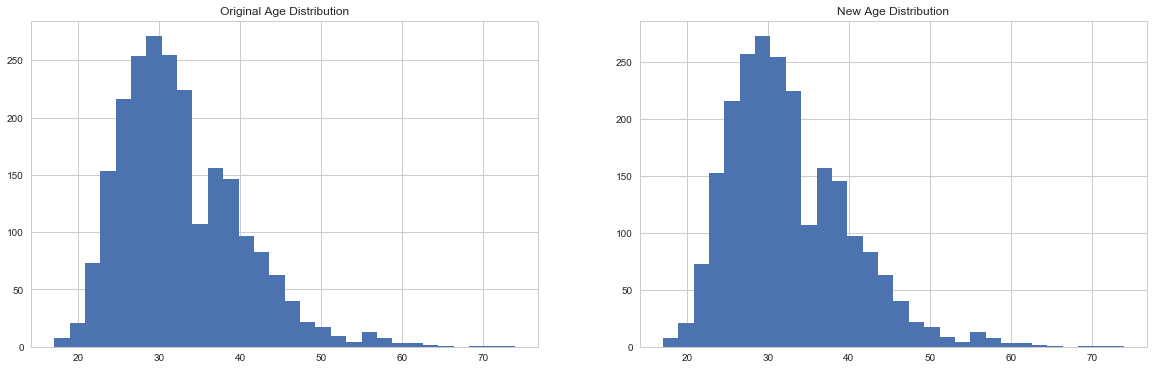

In [97]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(20, 6))
axis1.set_title('Original Age Distribution')
axis2.set_title('New Age Distribution')

# get median, Q1, Q3, and number of outlier ages
typical_ages = combined_df.loc[(combined_df.age >= 17) & (combined_df.age <= 90), 'age']
outlier_ages = combined_df.loc[(combined_df.age > 90) | (combined_df.age < 17), 'age']
median_age = typical_ages.median()
q1_age = typical_ages.quantile(0.25)
q3_age = typical_ages.quantile(0.75)
num_outlier_ages = len(outlier_ages)

# generate random ages between mean +/- std
new_ages = np.random.randint(q1_age, q3_age, size=num_outlier_ages)

# plot orig age distrib without the outliers
typical_ages.hist(bins=30, ax=axis1)

# fill outlier ages with new values
combined_df.loc[(combined_df.age > 90) | (combined_df.age < 17), 'age'] = new_ages
combined_df.age = combined_df.age.astype(int)

# plot age distribution with new values
combined_df.age.hist(bins=30, ax=axis2)

### Gender

In [98]:
# Separate all the unique responses into male, female, and other
all_gender = list(combined_df.gender.unique())
condit_female = ['Female', 'female', 'F', 'f', 'Femake', 'woman', 'Female ', 'Woman', 'femail',
                'I identify as female.', 'fm', 'female/woman', 'female ', 'fem',
                'Female (props for making this a freeform field, though)', ' Female']
condit_male = ['M', 'Male', 'male', 'maile', 'm', 'Make', 'Male ', 'Man', 'msle', 'Mail', 'Malr', 'man', 'Male.',
              'Sex is male', 'Dude', 'mail', 'male ']
condit_other = [i for i in all_gender if (i not in condit_male) and (i not in condit_female)] 

In [99]:
# Reduce to numerical values according to each category
# female = 1 ; male = 2 ; other = 3
combined_df.loc[(combined_df.gender.isin(condit_female)), 'gender'] = 1
combined_df.loc[(combined_df.gender.isin(condit_male)), 'gender'] = 2
combined_df.loc[(combined_df.gender.isin(condit_other)), 'gender'] = 3

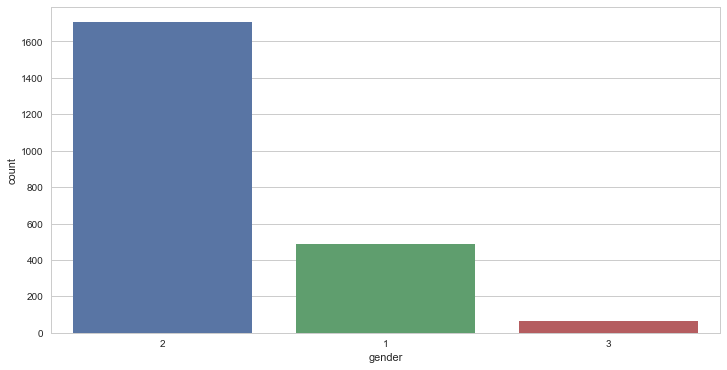

In [134]:
# plot counts for each gender
fig, axis = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x='gender', data=combined_df, ax=axis, order=combined_df.gender.value_counts().index)

### Location

In [101]:
# Drop country_live = Other
combined_df.drop(combined_df[combined_df.country_live == 'Other'].index, axis=0, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

In [102]:
# Put together the USA & US responses
combined_df.loc[(combined_df.country_live == 'United States of America'), 'country_live'] = 'United States'

In [104]:
# Set state_live = NaN for non USA countries
combined_df.loc[(
    combined_df.state_live.notnull()) & (
    combined_df.country_live != 'United States'), 'state_live'] = np.nan

In [106]:
# Set state_live = the mode (California) for USA responses with NaN state_live
combined_df.loc[(
    combined_df.state_live.isnull()) & (
    combined_df.country_live == 'United States'), 'state_live'] = 'California'

In [108]:
# Convert abbrev. state_live responses to full name
state_abbr_full = {'IL': 'Illinois', 'IN': 'Indiana', 'TX': 'Texas', 'TN': 'Tennessee', 'MI': 'Michigan',
                  'OH': 'Ohio', 'CA': 'California', 'CT': 'Connecticut', 'NY': 'New York', 'MA': 'Massachusetts',
                  'IA': 'Iowa', 'WA': 'Washington', 'WI': 'Wisconsin', 'UT': 'Utah', 'NM': 'New Mexico',
                  'OR': 'Oregon', 'FL': 'Florida', 'MN': 'Minnesota', 'MO': 'Missouri', 'AZ': 'Arizona',
                  'CO': 'Colorado', 'GA': 'Georgia', 'DC': 'District of Columbia', 'NE': 'Nebraska',
                  'MD': 'Maryland', 'PA': 'Pennsylvania', 'WV': 'West Virginia', 'OK': 'Oklahoma',
                  'NC': 'North Carolina', 'KS': 'Kansas', 'VA': 'Virginia', 'NH': 'New Hampshire', 'KY': 'Kentucky',
                  'AL': 'Alabama', 'NV': 'Nevada', 'NJ': 'New Jersey', 'SC': 'South Carolina', 'VT': 'Vermont',
                  'SD': 'South Dakota', 'ID': 'Idaho', 'RI': 'Rhode Island', 'WY': 'Wyoming', 'LA': 'Louisiana',
                  'ME': 'Maine', 'AK': 'Alaska', 'AR': 'Arkansas', 'DE': 'Delaware', 'HI': 'Hawaii',
                  'MS': 'Mississippi', 'MT': 'Montana', 'ND': 'North Dakota'}
combined_df.loc[(combined_df.state_live.str.len() == 2), 'state_live'] = combined_df.loc[(combined_df.state_live.str.len() == 2), 'state_live'].map(state_abbr_full)

In [110]:
# Create feature 'location' that splits USA by states and considers them on same level as other countries
combined_df['location'] = combined_df.country_live
combined_df.loc[(
    combined_df.state_live.notnull()) & (
    combined_df.country_live == 'United States'), 'location'] = combined_df.state_live

In [111]:
combined_df.head()

,date_submit,age,gender,country_live,state_live,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,year,month,week_day,hour,location
0,2014-08-27 11:29:31,37,1,United States,Illinois,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,2014,8,2,11,Illinois
1,2014-08-27 11:29:37,44,2,United States,Indiana,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,2014,8,2,11,Indiana
2,2014-08-27 11:29:44,32,2,Canada,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,2014,8,2,11,Canada
3,2014-08-27 11:29:46,31,2,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,2014,8,2,11,United Kingdom
4,2014-08-27 11:30:22,31,2,United States,Texas,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,2014,8,2,11,Texas


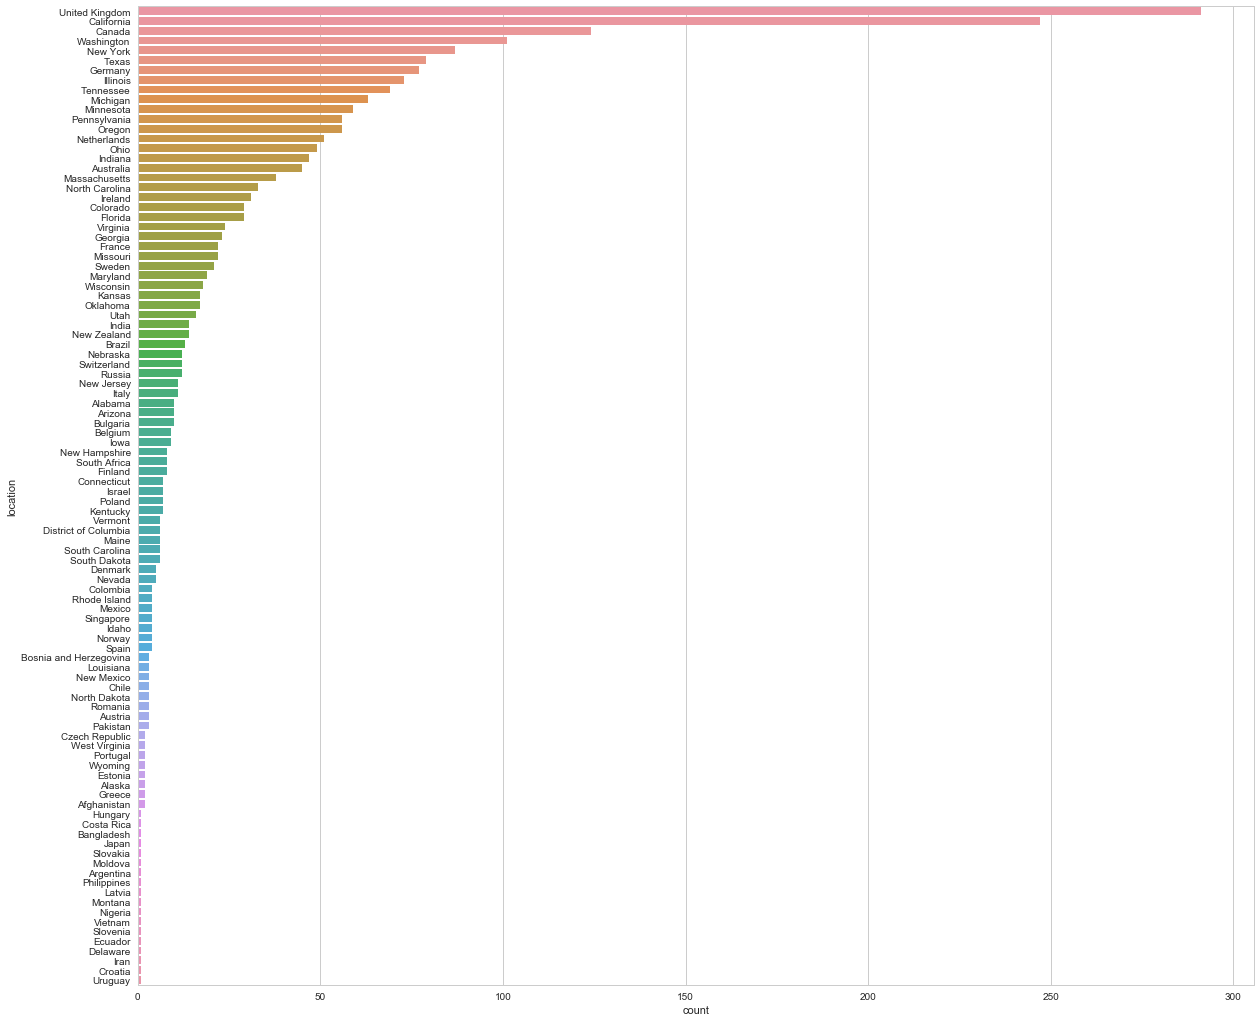

In [137]:
fig, axis = plt.subplots(1, 1, figsize=(20,18))
sns.countplot(y='location', data=combined_df, ax=axis, order=combined_df.location.value_counts().index)